# Plotting the energy balance model output

This notebook includes some basic plots you can use to inspect the energy balance model output. The output is a netcdf file so there are many ways you can visualize the data yourself, but I already created some basic plotting functions which are shown below.

In [2]:
%load_ext autoreload
%autoreload 2
from pebsi.processing.plotting_fxns import *
from objectives import *
import xarray as xr

Open the file and do a quick inspection of the data variables contained within

In [15]:
output_fn = '../Output/YOUR_FILE_NAME_HERE.nc'
output_fn = '../Output/gulkanaB_2025_09_11_4.nc'
ds = xr.open_dataset(output_fn)
ds

<xarray.Dataset> Size: 22MB
Dimensions:         (time: 3000, layer: 80)
Coordinates:
  * time            (time) datetime64[ns] 24kB 2024-04-17T18:00:00 ... 2024-0...
  * layer           (layer) int64 640B 0 1 2 3 4 5 6 7 ... 73 74 75 76 77 78 79
Data variables: (12/35)
    melt            (time) float64 24kB ...
    refreeze        (time) float64 24kB ...
    runoff          (time) float64 24kB ...
    accum           (time) float64 24kB ...
    cumrefreeze     (time) float64 24kB ...
    dh              (time) float64 24kB ...
    ...              ...
    layerOC         (time, layer) float64 2MB ...
    layerdust       (time, layer) float64 2MB ...
    SWnet           (time) float64 24kB ...
    LWnet           (time) float64 24kB ...
    NetRad          (time) float64 24kB ...
    MB              (time) float64 24kB ...
Attributes:
    glacier:          gulkana
    elevation:        1682.0 m a.s.l.
    site:             B
    from_AWS:         uwind, sp, SWin, LWin, rh, temp
    which_AWS:        gulkana 1682
    from_reanalysis:  tp, bcwet, bcdry, ocwet, ocdry, dustwet, dustdry
    which_re:         MERRA2
    run_start:        2024-04-17 18:00:00
    run_end:          2024-08-20 17:00:00
    model_run_date:   2025-09-11 15:40:47.290730
    time_elapsed:     54.6 s
    run_by:           torch

Visualize the snow layers for the duration of the model simulation

In [16]:
# ds['layerice'] = ds['layerdensity'] * ds['layerheight']
# simple_plot(ds, [ds.time.values[72], ds.time.values[72] + pd.Timedelta(days=2)], [['layerwater'],['layerrefreeze'], ['layergrainsize'], ['melt'],['albedo']], res='h')
# output_fn = '../Output/gulkanaB_2025_09_11_1.nc'
# ds_albedo_only = xr.open_dataset(output_fn)
# output_fn = '../Output/gulkanaB_2025_09_11_2.nc'
# ds_LW_too = xr.open_dataset(output_fn)
# start, end = (ds.time.values[0], ds.time.values[-1])
# plt.plot(ds.time.values, ds_albedo_only.LWout - ds_LW_too.LWout)

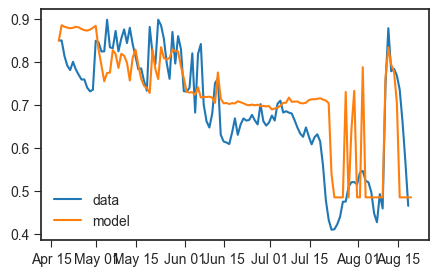

In [17]:
fig, ax = plt.subplots(figsize=(5,3))

# check which year to plot
if pd.to_datetime('2025-05-01') in ds.time.values:
    df = pd.read_csv('../climate_data/AWS/Processed/gulkana/gulkanaB2025_just_albedo.csv', index_col=0)
else:
    df = pd.read_csv('../climate_data/AWS/Processed/gulkana/gulkana2024_bothalbedo.csv', index_col=0)

# plot data
df.index = pd.to_datetime(df.index)
albedo = []
for day in pd.date_range(df.index[0], df.index[-1]):
    date_range = pd.date_range(str(day.date())+' 11:00', str(day.date())+' 14:00',freq='h')
    if np.all([d in df.index for d in date_range]):
        albedo_range = df.loc[date_range, 'albedo'].values
        albedo_range = albedo_range[albedo_range < 0.95]
        albedo.append(np.mean(albedo_range))
ax.plot(pd.date_range(df.index[0], df.index[-1])[:-1], albedo,label='data') #  + pd.Timedelta(days=365)

# plot model
da = ds.sel(time=pd.date_range(ds.time.values[0], ds.time.values[-1]))['albedo']
ax.plot(da.time.values, da.values, label='model')

# da = xr.open_dataset('../Output/gulkanaB_2025_09_11_0.nc')
# da = da.sel(time=pd.date_range(da.time.values[0], da.time.values[-1]))['albedo']
# ax.plot(da.time.values, da.values, label='model (spherical)')

# da = xr.open_dataset('../Output/gulkanaB_2025_09_11_1.nc')
# da = da.sel(time=pd.date_range(da.time.values[0], da.time.values[-1]))['albedo']
# ax.plot(da.time.values, da.values, label='model (flat->spherical)')

ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b %d'))
ax.tick_params(length=5)
ax.legend()
plt.show()

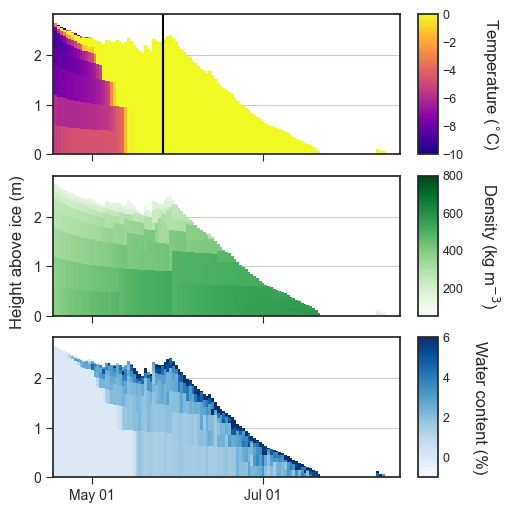

In [10]:
# Define the variables to plot 
# Options: layertemp, layerdensity, layerwater, layergrainsize, layerBC, layerOC, layerdust
layer_vars = ['layertemp','layerdensity','layerwater']

# Find the start and end timestamp
start = ds.time.values[0]
end = ds.time.values[-1]

# Create a daily timeseries to sample the model output
daily_dates = pd.date_range(start, end)

# Plot the layers
fig, axes = visualize_layers(ds, daily_dates, layer_vars)
axes[0].axvline(pd.to_datetime('2024-05-27'),color='k')
plt.show()

modeled balance -1.63
measured balance -1.79


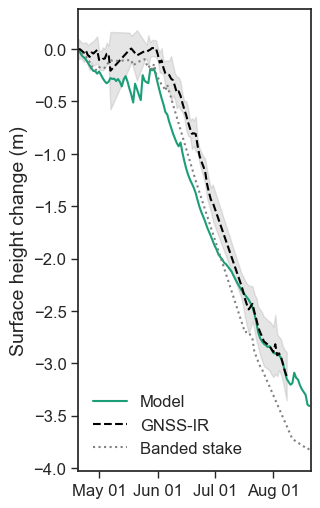

In [11]:
plot_2024_mass_balance(ds)
bal_meas = np.sum([ds.accum.sum() + ds.refreeze.sum() - ds.melt.sum()])
print(f'modeled balance {bal_meas:.2f}')
print('measured balance', -0.77 - 1.02)

Inspect the heat fluxes averaged for each hour of the day

In [ ]:
# Group variable terms by subplot
hour_vars = [['SWnet','LWnet','sensible','latent','rain','ground'],
             ['melt','refreeze','accum','runoff']]

# Plot hourly averages of these terms
plot_hours(ds, hour_vars)

Plot any other single variable for the entire timeseries

In [ ]:
# Define the variable
var = 'albedo'

# Define the time range
time = [ds.time.values[0], ds.time.values[-1]]

# Define the time resolution
resolution = 'd'

# Make a simple plot
simple_plot(ds, time, [[var]], res=resolution)
plt.show()

If you are done early, feel free to play around with some other settings and see how it changes these plots!
Some easy things to change:
- Add a command line argument for the initial snow (e.g. -s0=3) or firn depth (e.g. -f0=10)
- Add a command line argument to turn off albedo switches 
    - Turn off grain size growth (-switch_melt=0)
    - Change albedo to be a simple exponential lapse rate (-switch_melt=1)
    - Turn off fresh snow albedo reset (-switch_snow=0)
    - Turn off light-absorbing particles (-switch_LAPs=0) will do nothing for the test glacier because it already has no LAPs

In [ ]:
# Define input filepaths of two simulations
output_fp_1 = ''
output_fp_2 = ''

# Choose variable to compare across datasets 
var = 'albedo'

# Open datasets 
ds1 = xr.open_dataset(output_fp_1)
ds2 = xr.open_dataset(output_fp_2)

# Determine start and end time
time = [ds1.time.values[0], ds1.time.values[-1]]

# Compare simulations 
fig,ax = compare_runs([ds1,ds2],time,['First simulation','Second simulation'],var)
plt.show()

More information on the dataset storage:

- 2 coordinates
   - time : hourly timestep values
   - layer : indices for the maximum number of layers the model can store (allows for large amounts of snowfall; most layers are empty)
- 36 data variables
   - mass balance terms
      - melt, refreeze, runoff, accumulation ("accum") and net mass balance ("MB") in m w.e.
      - snow depth ("snowdepth") and surface height change ("dh") in meters
      - cumrefreeze in m w.e.
          - tracks the cumulative refreeze which resets annually to 0 (allows accounting of annual internal mass balance)
    - energy balance terms
      - shortwave ("SW") and longwave ("LW") incoming ("in"), outgoing ("out"), and net ("net") fluxes in W m-2
      - SWin_sky and _terr in W m-2 
          - indicate the portion of incoming shortwave that is from the sky versus terrain-scattered
      - latent, sensible, ground, and rain heat fluxes in W m-2
      - meltenergy (sum of all other heat fluxes) in W m-2
      - surface temperature ("surftemp") in degrees C
      - other meteorological inputs: air temperature ("airtemp") in degrees C and wind speed ("wind") in m s-1
    - layer variables
      - temperature ("temp") in degrees C
      - density in kg m-3
      - liquid water content ("water") in masss %
      - grain size ("grainsize") in um
      - refrozen content in mm w.e. / kg m-2
      - black carbon ("BC"), organic carbon ("OC") and dust content in ppb
- several attributes
    - glacier name, elevation, site of the simulation
    - from_AWS : which variables came from the weather station dataset
    - which_AWS : which AWS those variables came from
    - from_reanalysis : which variables came from reanalysis data
    - which_reanalysis : which reanalysis dataset those variables came from
    - run_start and run_end : the simulation start and end timestamp
    - model_run_date : the day this simulation was performed
    - time_elapsed : how long it took to run this simulation
    - run_by : name of the machine that ran the code